# import

In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pickle
from pyvino.detector.detector import DetectorHumanPose
import sys
sys.path.append('..')
from actrec.util import moving_average, flatten_data

 # path

In [71]:
notebook_name = os.path.basename(os.getcwd())
timestamp = notebook_name.split('_')[1]
timestamp

'07'

In [72]:
path_movie_dir = '../data/movie/'
path_save_dir = os.path.join('../data/06_Evaluation/', timestamp)
if not os.path.exists(path_save_dir):
    os.makedirs(path_save_dir)
# path_save_file = os.path.join(path_save_dir, 'test_data.csv')
path_save_file = os.path.join(path_save_dir, 'test_4.csv')

In [73]:
path_label_name_file = '../data/labels/labels_num.csv'
path_action_dir = os.path.join('../data/01_DataProcessing/', timestamp)
path_point_dir = os.path.join('../data/02_GetPoints/', timestamp)
path_split_dir = os.path.join('../data/04_Split/', timestamp)
path_test_file_dir = os.path.join(path_split_dir, 'test')
path_test_file = os.path.join(path_test_file_dir, 'test_4.csv')
path_model_dir = os.path.join('../data/05_train/', timestamp)
path_model_file = os.path.join(path_model_dir, 'model.pkl')

In [74]:
file_names = ['forehand', 'backhand', 'foreslice', 'backslice']
# file_names = ['forehand']
movie_names = [file_name + '.mp4' for file_name in file_names]
points_file_names = [file_name + '.csv' for file_name in file_names]

file_names = ['test']
movie_names = [file_name + '.MOV' for file_name in file_names]
points_file_names = [file_name + '.csv' for file_name in file_names]

In [75]:
path_model_file

'../data/05_train/07/model.pkl'

In [76]:
path_split_dir = os.path.join('../data/04_Split/', timestamp)
path_test_file_dir = os.path.join(path_split_dir, 'test')

# data

In [77]:
objective = 'action_gt_num'

num = 3
data_name = points_file_names[num]

path_test_dir = os.path.join(path_split_dir, 'test')
path_test_file = os.path.join(path_test_dir, data_name)
test_data = pd.read_csv(path_test_file)

In [78]:
label_names = pd.read_csv(path_label_name_file)

In [79]:
label_names

,action_gt_name,action_gt_num
0,idle,0
1,forehand,1
2,backhand,2
3,foreslice,3
4,backslice,4


# モデル読み込み

In [80]:
gbm = pickle.load(open(path_model_file, "rb"))
path_model_file

'../data/05_train/07/model.pkl'

In [81]:
feature_name_list = gbm.feature_name()

# process

## moving average

In [82]:
target_columns = ['RShoulder_x', 'RShoulder_y', 'RElbow_x', 'RElbow_y', 'RWrist_x', 'RWrist_y', 
                         'LShoulder_x', 'LShoulder_y', 'LElbow_x', 'LElbow_y', 'LWrist_x', 'LWrist_y']

# parameters

In [83]:
frame_length = 15
assert frame_length == int(len(feature_name_list) / len(target_columns))

## frames as one row data

In [84]:
new_data_df = None
for num, points_file_name in enumerate(points_file_names):
    print(points_file_name)
    path_file = os.path.join(path_test_file_dir, points_file_name)
    data_df = pd.read_csv(path_file, index_col='frame_num')
    units_df = None
    for idx in data_df.index[frame_length:len(data_df)]:
        unit_df = data_df.loc[idx - frame_length: idx]
        y = unit_df[objective]
        X = unit_df.drop(columns=[objective]).loc[:, target_columns]
        unit_df = flatten_data(X, y, objective)
        if units_df is None:
            units_df = unit_df
        else:
            units_df = pd.concat([units_df, unit_df], axis=0, sort=False)
    path_save_file = os.path.join(path_save_dir, points_file_name)
    units_df.to_csv(path_save_file)
    if new_data_df is None:
        new_data_df = units_df
    else:
        new_data_df = pd.concat([new_data_df, units_df], axis=0, sort=False)
test_data_df = new_data_df.copy()
test_data_df.to_csv(path_test_file)

forehand.csv
backhand.csv
foreslice.csv
backslice.csv


In [113]:
new_data_df.groupby(objective).count()

,RShoulder_x_-15,RShoulder_y_-15,RElbow_x_-15,RElbow_y_-15,RWrist_x_-15,RWrist_y_-15,LShoulder_x_-15,LShoulder_y_-15,LElbow_x_-15,LElbow_y_-15,...,RElbow_x_0,RElbow_y_0,RWrist_x_0,RWrist_y_0,LShoulder_x_0,LShoulder_y_0,LElbow_x_0,LElbow_y_0,LWrist_x_0,LWrist_y_0
action_gt_num,,,,,,,,,,,,,,,,,,,,,
0,2617,2617,2237,2237,2073,2073,2550,2550,2151,2151,...,2186,2186,1992,1992,2509,2509,2247,2247,2074,2074
1,260,260,254,254,260,260,258,258,239,239,...,247,247,232,232,259,259,208,208,220,220
2,364,364,339,339,257,257,364,364,363,363,...,337,337,283,283,343,343,260,260,286,286
3,234,234,234,234,230,230,223,223,176,176,...,231,231,221,221,225,225,167,167,181,181
4,302,302,270,270,191,191,312,312,308,308,...,285,285,239,239,314,314,311,311,295,295


In [118]:
test_data_df['dummy'] = 1
test_data_df.groupby(objective).count()['dummy']

action_gt_num
0    2850
1     260
2     364
3     234
4     348
Name: dummy, dtype: int64

## テストデータ

In [85]:
X_test_data_df = test_data_df.drop([objective], axis=1)
y_test_data_df = test_data_df[objective]

# 予測

In [86]:
y_pred = gbm.predict(X_test_data_df, num_iteration=gbm.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

In [87]:
objective_pred = 'action_pred_num'

In [88]:
test_data_df[objective_pred] = y_pred
test_data_df = test_data_df.reset_index(drop=True)

# 精度

## 計算

In [90]:
accuracy_all = np.sum(test_data_df[objective] == test_data_df[objective_pred]) / len(test_data_df)

In [91]:
print('accuracy: ', round(accuracy_all*100, 2), ' %')

accuracy:  89.32  %


In [92]:
objective_rev_dict = label_names.to_dict()['action_gt_name']

In [93]:
test_data_df['action_gt_name'] = test_data_df[objective].apply(lambda x: objective_rev_dict[x])
test_data_df['action_pred_name'] = test_data_df[objective_pred].apply(lambda x: objective_rev_dict[x])

In [94]:
test_data_df.columns

Index(['RShoulder_x_-15', 'RShoulder_y_-15', 'RElbow_x_-15', 'RElbow_y_-15',
       'RWrist_x_-15', 'RWrist_y_-15', 'LShoulder_x_-15', 'LShoulder_y_-15',
       'LElbow_x_-15', 'LElbow_y_-15',
       ...
       'LShoulder_x_0', 'LShoulder_y_0', 'LElbow_x_0', 'LElbow_y_0',
       'LWrist_x_0', 'LWrist_y_0', 'action_gt_num', 'action_pred_num',
       'action_gt_name', 'action_pred_name'],
      dtype='object', length=196)

# 評価

## confusion matrix

In [95]:
from sklearn.metrics import confusion_matrix

In [96]:
objective_names = list(objective_rev_dict.values())
objective_names

['idle', 'forehand', 'backhand', 'foreslice', 'backslice']

In [97]:
confusion_matrix_df = confusion_matrix(test_data_df[objective], test_data_df[objective_pred])

In [98]:
objective_names_pred = [objective_name + '_pred' for objective_name in objective_names]
objective_names_gt = [objective_name + '_gt' for objective_name in objective_names]

objective_names_pred = [objective_name + '_pred' for objective_name in ['idle', 'forehand']]
objective_names_gt = [objective_name + '_gt' for objective_name in ['idle', 'forehand']]

In [99]:
confusion_matrix_df

array([[2684,   14,   40,   13,   99],
       [  55,  188,    0,   17,    0],
       [  43,    0,  321,    0,    0],
       [  87,   12,    0,  135,    0],
       [  52,    0,    1,    0,  295]])

In [100]:
confusion_matrix_df = pd.DataFrame(confusion_matrix_df, columns=objective_names_pred, index=objective_names_gt)
confusion_matrix_df

,idle_pred,forehand_pred,backhand_pred,foreslice_pred,backslice_pred
idle_gt,2684,14,40,13,99
forehand_gt,55,188,0,17,0
backhand_gt,43,0,321,0,0
foreslice_gt,87,12,0,135,0
backslice_gt,52,0,1,0,295


In [104]:
# Precision
confusion_matrix_df / confusion_matrix_df.sum(axis=0) * 100

,idle_pred,forehand_pred,backhand_pred,foreslice_pred,backslice_pred
idle_gt,91.886340,6.542056,11.049724,7.878788,25.126904
forehand_gt,1.882917,87.850467,0.000000,10.303030,0.000000
backhand_gt,1.472099,0.000000,88.674033,0.000000,0.000000
foreslice_gt,2.978432,5.607477,0.000000,81.818182,0.000000
backslice_gt,1.780212,0.000000,0.276243,0.000000,74.873096


In [105]:
# Recall
(confusion_matrix_df.T / confusion_matrix_df.sum(axis=1)).T * 100

,idle_pred,forehand_pred,backhand_pred,foreslice_pred,backslice_pred
idle_gt,94.175439,0.491228,1.403509,0.456140,3.473684
forehand_gt,21.153846,72.307692,0.000000,6.538462,0.000000
backhand_gt,11.813187,0.000000,88.186813,0.000000,0.000000
foreslice_gt,37.179487,5.128205,0.000000,57.692308,0.000000
backslice_gt,14.942529,0.000000,0.287356,0.000000,84.770115


## feature importance

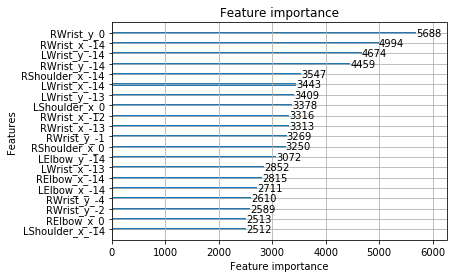

In [106]:
lgb.plot_importance(gbm, max_num_features=20)